Month,1,2,3,4,5,6
Product,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


Month,1,2,3,4,5,6
Product,,,,,,
Beef Chicharon,12554835,12991299,12750984,12847110,13026372,12862698
Gummy Vitamins,14521500,14970000,15217500,14763000,14922000,14970000
Gummy Worms,1433850,1499400,1497900,1506450,1470150,1490100
Kimchi and Seaweed,7731124,7949251,7963633,7926879,7808627,8073096
Nutrional Milk,19356730,19285090,19653240,19474140,19663190,19436330
Orange Beans,1945026,1997363,1912589,1972886,1982836,2011094
Yummy Vegetables,4979500,5128000,4948000,4930500,4867500,4861000


Month,1,2,3,4,5,6
Engaged,6588,5172,5210,5151,5143,5195
Inactive,0,1416,1747,1909,1917,1835
Repeaters,0,13219,13253,13178,13124,13220


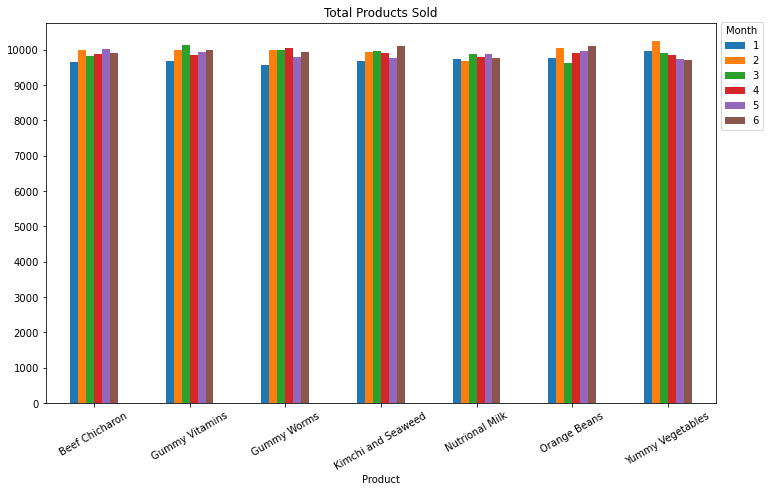

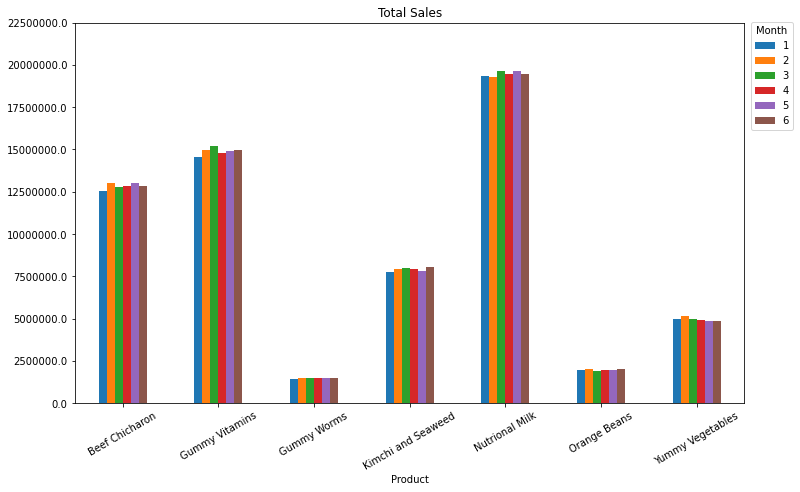

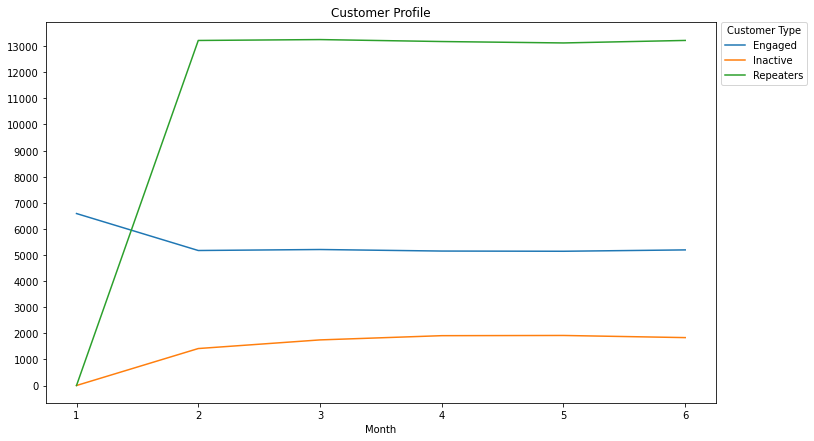

In [2]:
import json
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

response = open('transaction-data-adhoc-analysis.json')
data = json.load(response)

df = pd.DataFrame(data)

'''First Table'''

#Separating individual transactions
df['transaction_items'] = df['transaction_items'].str.split(';')
df = df.explode('transaction_items')

#Separating Brand, Product, and Quantity + simplifying the dataframe
item_info = df['transaction_items'].str.split(',',expand = True)
df['Brand'] = item_info[0]
df['Product'] = item_info[1]
df['Quantity'] = item_info[2]
df = df.reset_index()
df.drop(columns = ['transaction_items','index','address','birthdate','mail','sex','username'],inplace = True)

#Quantity as int
df['Quantity'] = df['Quantity'].str.extract('(\d+)',expand=False).astype(int)

#Getting Months
df['transaction_date'] = df['transaction_date'].astype('datetime64[ns]')
df['Month'] = df['transaction_date'].dt.month

#Make first pivot table
total_products_sold = df.pivot_table(values='Quantity',index='Product',columns='Month',aggfunc='sum')

display(total_products_sold)

'''Second Table'''

orig_df = pd.DataFrame(data)

#Isolate most important transaction information
transactions = orig_df[['transaction_items','transaction_value']]

#Get single product transactions
single_product = transactions['transaction_items'].str.contains(';')==False
single_product_transactions = transactions[single_product]

#From single product transactions, get one-quantity transactions
quantity_one = single_product_transactions['transaction_items'].str.contains('x1')==True
quantity_one_transactions = single_product_transactions[quantity_one]

#Drop duplicates + reset index
unique_quantity_one_transactions = quantity_one_transactions.drop_duplicates(subset='transaction_value')
unique_quantity_one_transactions = unique_quantity_one_transactions.reset_index()
unique_quantity_one_transactions.drop(columns = ['index'],inplace=True)

#Again, separate brand, product, and quantity
uqot_info = unique_quantity_one_transactions['transaction_items'].str.split(',',expand=True)
unique_quantity_one_transactions['Brand'] = uqot_info[0]
unique_quantity_one_transactions['Product'] = uqot_info[1]
unique_quantity_one_transactions['Quantity'] = uqot_info[2]
unique_quantity_one_transactions.drop(columns = ['transaction_items','Quantity'],inplace=True)

#Make second pivot table
grouped_df = df.groupby(['Product','Month'])
new_grouped_df = grouped_df['Quantity'].sum().reset_index()
total_sales = new_grouped_df.merge(unique_quantity_one_transactions, on='Product', how='left')
condition = total_sales.Quantity * total_sales.transaction_value
total_sales['Total Sales'] = condition

total_sales_pivot = total_sales.pivot_table(values = 'Total Sales',index = 'Product',columns = 'Month')

display(total_sales_pivot)

'''Third Table'''

'''Customer Profiles'''

#New DF for this section
df_customers = pd.DataFrame(data)
df_customers['transaction_items'] = df_customers['transaction_items'].str.split(';')
df_customers = df_customers.explode('transaction_items')

item_info_customers = df_customers['transaction_items'].str.split(',',expand = True)
df_customers['Brand'] = item_info_customers[0]
df_customers['Product'] = item_info_customers[1]
df_customers['Quantity'] = item_info_customers[2]
df_customers = df_customers.reset_index()
df_customers.drop(columns = ['transaction_items','index','address','birthdate','mail','sex','username'],inplace = True)

df_customers['transaction_date'] = df_customers['transaction_date'].astype('datetime64[ns]')
df_customers['Month'] = df['transaction_date'].dt.month

#Months list
months_list = [1,2,3,4,5,6]

'''Customers per Month'''

def monthly_customers(x):
    condition = df_customers['Month'] == x
    unique_customers = df_customers[condition].drop_duplicates(subset=['name'],keep='first')['name']
    unique_customers_set = set(unique_customers)
    sorted_ucs = sorted(unique_customers_set)
    return sorted_ucs

monthly_customers_dict = {i:monthly_customers(i) for i in months_list}

'''Repeating Customers'''

#Function for Repeaters
def repeating_customers(x):
    if months_list.index(x) == 0:
        return 0

    else:
        current_previous_list = [x,months_list[months_list.index(x)-1]]

        condition = df_customers["Month"].isin(current_previous_list)
        current = df_customers[condition]
        unique_current = current.drop_duplicates(subset = ['name', 'Month'], keep='first')
        
        repeater_count = len(unique_current)

        return repeater_count

repeaters = pd.Series({i:repeating_customers(i) for i in months_list})

'''Inactive Customers'''

#Function for Inactive Customers
def inactive_customers(x):
    index = months_list.index(x)
    previous = months_list[:index]
    
    current_condition = df_customers['Month'] == x
    filtered_current = df_customers[current_condition].drop_duplicates(subset=['name'])
    filtered_current_set = set(filtered_current['name'])
    
    previous_condition = df_customers['Month'].isin(previous)
    filtered_previous = df_customers[previous_condition].drop_duplicates(subset=['name'])
    filtered_previous_set = set(filtered_previous['name'])
    
    inactive_count = len(filtered_previous_set.difference(filtered_current_set))
    
    return inactive_count
    
inactive = pd.Series({i:inactive_customers(i) for i in months_list})

'''Engaged Customers'''

#Function for Engaged Customers
def engaged_customers(x):
    i = 0
    first_month = months_list[0]
    initial_set = set(monthly_customers_dict[first_month])
    
    while i <= months_list.index(x):
        current = months_list[i]
        current_set = set(monthly_customers_dict[current])
        engaged_customers = initial_set.intersection(current_set)
        i = i+1
        
        if i > months_list.index(x):
            engaged_count = len(engaged_customers)
            return engaged_count

engaged = pd.Series({i:engaged_customers(i) for i in months_list})

#Make new dataframe
customer_profile_dict = {'Repeaters':repeaters,'Inactive':inactive,'Engaged':engaged}

customer_profile_df = pd.DataFrame(customer_profile_dict)
customer_profile_df = customer_profile_df.reset_index()
customer_profile_df = customer_profile_df.rename(columns={'index':'Month'})

#Make Pivot Table
customer_profile_pivot = customer_profile_df.pivot_table(values = ['Repeaters','Inactive','Engaged'], columns = 'Month')

display(customer_profile_pivot)

'''Graphs'''

'''Bar Graph for Total Products Sold'''

#Plotting the Graph
total_products_sold_graph = total_products_sold.plot.bar(figsize=(12,7),title='Total Products Sold',rot=30)

#Adjusting Aesthetics
total_products_sold_graph.legend(bbox_to_anchor = (1.00, 1.015),title='Month')
total_products_sold_graph.yaxis.set_ticks(np.arange(0,11000,1000))

'''Bar Graph for Total Sales'''

#Plotting the graph
total_sales_graph = total_sales_pivot.plot.bar(figsize=(12,7),title='Total Sales',rot=30)

#Adjusting Aesthetics
total_sales_graph.legend(bbox_to_anchor = (1.08, 1.015),title='Month')

#Expanding Scientific Notation
yy, locs = plt.yticks()
ll = ['%.1f' % a for a in yy]
plt.yticks(yy, ll)

'''Line Graph for Customer Profile'''

#Transpose Table
transposed_pivot = customer_profile_pivot.transpose()

#Plotting the Graph
customer_profile_graph = transposed_pivot.plot.line(figsize=(12,7),title='Customer Profile',rot=0)

#Adjusting Aesthetics
customer_profile_graph.legend(bbox_to_anchor = (1.00, 1.015),title='Customer Type')
customer_profile_graph.yaxis.set_ticks(np.arange(0,14000,1000))

plt.show()